In [2]:
import pandas as pd
import torch
import numpy as np
import sklearn
from importlib import reload
#import matplotlib.pyplot as plt
#%matplotlib inline

# Character Embedding

In [5]:
dFile='cmudict.txt'

In [6]:
from vocab import build_vocab, sentence_to_tensor

char_seqs=[]
char_set=set()
with open(dFile) as d: 
    for line in d: 
        line=line.strip().split()
        word=line[0]
        chars=line[1:]

        char_seqs.append(chars)
        char_set |=set(chars)
                
c2i, i2c = build_vocab(char_set)

In [7]:
from lm import NameGenerator, train_output_self

char_model = NameGenerator(
    input_vocab_size=len(c2i),
    n_embedding_dims=32,
    n_hidden_dims=20,
    n_lstm_layers=1,
    output_vocab_size=len(c2i)
)

x = sentence_to_tensor("B AH1 D ER0 F L AY2".split(), c2i, True) # make sure to pad w/ bos/eos symbols
y_hat, lstm_hidden_state = char_model(x, char_model.init_hidden())
y_hat.shape # should be 1x12x78 (1 x len("Test input")+2 x len(c2i))

torch.Size([1, 9, 85])

In [27]:
len(char_seqs)

133279

In [8]:
train_output_self(char_model, epochs=5, training_data=char_seqs, c2i=c2i)

0/133279, loss: 4.439957141876221


KeyboardInterrupt: 

In [14]:
#torch.save(char_model,'char_lstm.mod')
char_model2=torch.load('char_lstm_bi.mod')

In [10]:
from lm import compute_prob

compute_prob(char_model2, "B AH1 D ER0 F L AY2".split(), c2i)

3.7789344787597656e-05

In [11]:
compute_prob(char_model2, "D B F L".split(), c2i)

0.09517431259155273

In [15]:
embedding_weights=char_model2.input_lookup.weight


pd.DataFrame(embedding_weights.detach().numpy())


saveme=pd.DataFrame(embedding_weights.detach().numpy())

saveme['char']=''

for c, i in c2i.items():
    saveme.loc[i,'char']=c

saveme.to_csv('embedding_weights_preClass_bi.csv')


In [13]:
char_modelN= NameGenerator(
    input_vocab_size=len(c2i),
    n_embedding_dims=32,
    n_hidden_dims=20,
    n_lstm_layers=1,
    output_vocab_size=len(c2i)
)
embedding_weights=char_modelN.input_lookup.weight


pd.DataFrame(embedding_weights.detach().numpy())


saveme=pd.DataFrame(embedding_weights.detach().numpy())

saveme['char']=''

for c, i in c2i.items():
    saveme.loc[i,'char']=c

saveme.to_csv('embedding_weights_null.csv')



# Binary Phonological Classifier

In [37]:
import vocab
from sklearn.model_selection import train_test_split
from ast import literal_eval

mappdFile='mappd_example.csv'
mappd=pd.read_csv(mappdFile)

input_label='Production.Arpabet'
input_label_2='Target ARPAbet'

training_col_1=mappd.loc[:,input_label].apply(lambda x: list(literal_eval(x)))
training_col_2=mappd.loc[:,input_label_2].apply(lambda x: literal_eval(x)[0])

codes_label='Code in our Taxonomy'
codes=set(mappd.loc[:,codes_label])
binary_dict={'Formal':1,'Mixed':1,"P.R.Neologism":1,'Semantic':0, 'Other':0,'A.Neologism':0}

label_label='Phonological'
mappd[label_label]=mappd.loc[:,codes_label].apply(lambda x: binary_dict[x])
label_col=mappd.loc[:,label_label]

X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(training_col_1, training_col_2, label_col, test_size=0.33)
X1_val, X1_test,X2_val, X2_test, y_val, y_test=train_test_split(X1_test, X2_test, y_test, test_size=0.5)


#o2i, i2o=build_vocab(outputs, pad_syms=False)


In [38]:
import lm
reload(lm)

phon_model = lm.ProductionPhonClassifier(
    input_vocab_size=len(c2i),
    n_embedding_dims=32,
    n_hidden_dims=20,
    n_lstm_layers=1,
    output_class_size=2,
    pretrained_embedding=embedding_weights
)

x = sentence_to_tensor("B AH1 D ER0 F L AY2".split(), c2i, False)
x_p= sentence_to_tensor("B F L AY2".split(), c2i, False)

y_hat, lstm_hidden_state = phon_model(x_p,x, phon_model.init_hidden())
y_hat.shape # should be 1x12x78 (1 x len("Test input")+2 x len(c2i))

torch.Size([1, 2])

In [39]:
reload(lm)
phon_model=lm.train_output_binary(phon_model, epochs=10, training_inputs_1=X1_train,training_inputs_2=X2_train, c2i=c2i, training_outputs=y_train)

0/4690, loss: 0.7247909307479858
1000/4690, loss: 0.4509950876235962
2000/4690, loss: 0.7172232866287231
3000/4690, loss: 0.4155000150203705
4000/4690, loss: 0.8606311082839966
0/4690, loss: 1.0418462753295898
1000/4690, loss: 0.8177490234375
2000/4690, loss: 0.1429152488708496
3000/4690, loss: 0.44229763746261597
4000/4690, loss: 0.7052188515663147
0/4690, loss: 0.736798882484436
1000/4690, loss: 0.12787127494812012
2000/4690, loss: 0.2286267876625061
3000/4690, loss: 0.4744734466075897
4000/4690, loss: 1.2261219024658203
0/4690, loss: 0.6000381708145142
1000/4690, loss: 0.33415183424949646
2000/4690, loss: 0.25707298517227173
3000/4690, loss: 0.6477929353713989
4000/4690, loss: 0.3898521065711975
0/4690, loss: 0.6630539894104004
1000/4690, loss: 0.13890516757965088
2000/4690, loss: 0.4454132318496704
3000/4690, loss: 0.31862008571624756
4000/4690, loss: 2.0978927612304688
0/4690, loss: 0.8018059134483337
1000/4690, loss: 0.6306855082511902
2000/4690, loss: 0.33083388209342957
3000/46

In [40]:
p_embedding_weights=phon_model.input_lookup.weight


saveme=pd.DataFrame(p_embedding_weights.detach().numpy())

saveme['char']=''

for c, i in c2i.items():
    saveme.loc[i,'char']=c

saveme.to_csv('embedding_weights_PhonClass')


In [41]:
from sklearn.metrics import classification_report, confusion_matrix

eval_pd=pd.DataFrame()
eval_pd['X1']=X1_train
eval_pd['X2']=X2_train
eval_pd['y']=y_train

acc, predictions=lm.eval_acc_binary(phon_model, eval_pd, c2i, i2c)
eval_pd['yhat']=predictions

print(classification_report(y_train, predictions))
print('Accuracy:',acc)

             precision    recall  f1-score   support

          0       0.75      0.68      0.71      1963
          1       0.78      0.83      0.81      2727

avg / total       0.77      0.77      0.77      4690

Accuracy: 0.7680170575692964


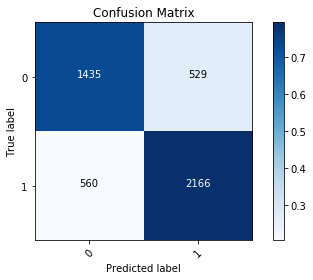

In [41]:
cm = confusion_matrix(y_train, predictions)
lm.pretty_conf_matrix(cm, [0,1])

In [72]:
eval_pd['codes']=mappd[codes_label]
eval_pd['correct']= eval_pd['y']==eval_pd['yhat']

eval_pd.groupby(['y']).count()

,X1,X2,yhat,codes,correct,P.ortho,T.ortho
y,,,,,,,
0,489,489,489,489,489,389,489
1,666,666,666,666,666,361,666


In [49]:
from sklearn.metrics import classification_report, confusion_matrix

eval_pd=pd.DataFrame()
eval_pd['X1']=X1_val
eval_pd['X2']=X2_val
eval_pd['y']=y_val

acc, predictions=lm.eval_acc_binary(phon_model, eval_pd, c2i, i2c)
eval_pd['yhat']=predictions

print(classification_report(y_val, predictions))
print('Accuracy:',acc)

             precision    recall  f1-score   support

          0       0.59      0.60      0.60       489
          1       0.70      0.70      0.70       666

avg / total       0.66      0.66      0.66      1155

Accuracy: 0.6571428571428571


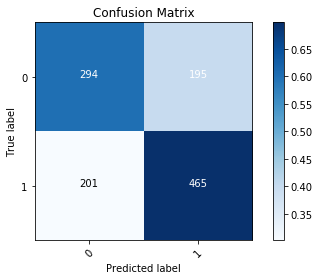

In [50]:
cm = confusion_matrix(y_val, predictions)
lm.pretty_conf_matrix(cm, [0,1])

In [90]:
eval_pd['codes']=mappd[codes_label]
eval_pd['P.ortho']=mappd['Production.Orthographic']
eval_pd['T.ortho']=mappd['Target']
eval_pd['correct']= eval_pd['y']==eval_pd['yhat']


#eval_pd[eval_pd.codes.isin(['Semantic'])].dropna().sort_values(['correct','codes'])

#eval_pd.groupby(['T.ortho', 'y','yhat']).sum().to_csv('+-Pbyword.csv')
eval_pd[eval_pd.loc[:,'T.ortho'].isin(['thermometer'])].dropna().sort_values(['correct','codes'])


,X1,X2,y,yhat,codes,correct,P.ortho,T.ortho
1781,"[D, AY1, N, AH, S, AO, R]","[TH, ER0, M, AA1, M, AH0, D, ER0]",1,1,Formal,True,dinosaur,thermometer
6854,"[B, IH1, T, S]","[TH, ER0, M, AA1, M, AH0, D, ER0]",0,0,Other,True,bits,thermometer
106,"[TH, ER1, M, AH, S, T, AE, T]","[TH, ER0, M, AA1, M, AH0, D, ER0]",0,0,Semantic,True,thermostat,thermometer
2274,"[TH, ER1, M, AH, S, T, AE, T]","[TH, ER0, M, AA1, M, AH0, D, ER0]",0,0,Semantic,True,thermostat,thermometer


# LSTM 2

In [20]:
import vocab
from sklearn.model_selection import train_test_split
from ast import literal_eval

mappdFile='mappd_example.csv'
mappd=pd.read_csv(mappdFile)

output_label='Code in our Taxonomy'
outputs=set(mappd.loc[:,output_label])
o2i, i2o=build_vocab(outputs, pad_syms=False)


input_label='Production.Arpabet'
input_label_2='Target ARPAbet'

training_col_1=mappd.loc[:,input_label].apply(lambda x: list(literal_eval(x)))
training_col_2=mappd.loc[:,input_label_2].apply(lambda x: literal_eval(x)[0])

label_col=mappd.loc[:,output_label]

X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(training_col_1, training_col_2, label_col, test_size=0.33)
X1_val, X1_test,X2_val, X2_test, y_val, y_test=train_test_split(X1_test, X2_test, y_test, test_size=0.5)


In [17]:
import lm
reload(lm)

model2 = lm.ProductionClassifier2(
    input_vocab_size=len(c2i),
    n_embedding_dims=32,
    n_hidden_dims=20,
    n_lstm_layers=1,
    output_class_size=len(outputs),
    pretrained_embedding=embedding_weights
)

x = sentence_to_tensor("B AH1 D ER0 F L AY2".split(), c2i, False)
x_p= sentence_to_tensor("B F L AY2".split(), c2i, False)

y_hat, lstm_hidden_state = model2(x_p,x, model2.init_hidden())
y_hat.shape # should be 1x12x78 (1 x len("Test input")+2 x len(c2i))

torch.Size([1, 6])

In [21]:
model2=lm.train_output_y2(model2, epochs=10, training_inputs_1=X1_train,training_inputs_2=X2_train, c2i=c2i, training_outputs=y_train, o2i=o2i)

0/4690, loss: 1.0943888425827026
1000/4690, loss: 1.1017417907714844
2000/4690, loss: 0.39940953254699707
3000/4690, loss: 1.6374297142028809
4000/4690, loss: 0.9147272109985352
0/4690, loss: 0.8910541534423828
1000/4690, loss: 2.430110216140747
2000/4690, loss: 2.5431835651397705
3000/4690, loss: 0.5326027870178223
4000/4690, loss: 3.5679574012756348
0/4690, loss: 2.7371878623962402
1000/4690, loss: 0.887198805809021
2000/4690, loss: 2.92490816116333
3000/4690, loss: 0.9368488788604736
4000/4690, loss: 0.6155571937561035
0/4690, loss: 3.749026298522949
1000/4690, loss: 1.1131742000579834
2000/4690, loss: 3.081941604614258
3000/4690, loss: 1.88386869430542
4000/4690, loss: 1.7404918670654297
0/4690, loss: 0.393949031829834
1000/4690, loss: 2.2544941902160645
2000/4690, loss: 0.398331880569458
3000/4690, loss: 1.960289478302002
4000/4690, loss: 1.6636217832565308
0/4690, loss: 1.8733487129211426
1000/4690, loss: 0.260317325592041
2000/4690, loss: 0.05130720138549805
3000/4690, loss: 1.1

In [22]:
c_embedding_weights=model2.input_lookup.weight
saveme=pd.DataFrame(p_embedding_weights.detach().numpy())
p_embedding_weights=phon_model.input_lookup.weight
saveme['char']=''

for c, i in c2i.items():
    saveme.loc[i,'char']=c

saveme.to_csv('embedding_weights_2Class.csv')

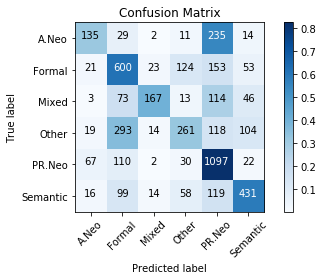

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

eval_pd=pd.DataFrame()
eval_pd['X1']=X1_train
eval_pd['X2']=X2_train
eval_pd['y']=y_train

acc, predictions=lm.eval_acc2(model2, eval_pd, c2i, i2c, o2i, i2o)
eval_pd['yhat']=predictions

cm = confusion_matrix(y_train, predictions)
lm.pretty_conf_matrix(cm, ['A.Neo','Formal','Mixed','Other','PR.Neo','Semantic'])


In [21]:
acc

0.573773987206823

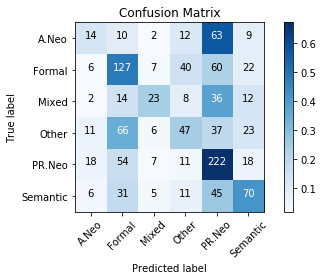

In [22]:
eval_pd=pd.DataFrame()
eval_pd['X1']=X1_val
eval_pd['X2']=X2_val
eval_pd['y']=y_val

acc, predictions=lm.eval_acc2(model2, eval_pd, c2i, i2c, o2i, i2o)
eval_pd['yhat']=predictions

cm = confusion_matrix(y_val, predictions)
lm.pretty_conf_matrix(cm, ['A.Neo','Formal','Mixed','Other','PR.Neo','Semantic'])


In [23]:

print(classification_report(y_val, predictions))

               precision    recall  f1-score   support

  A.Neologism       0.25      0.13      0.17       110
       Formal       0.42      0.48      0.45       262
        Mixed       0.46      0.24      0.32        95
        Other       0.36      0.25      0.29       190
P.R.Neologism       0.48      0.67      0.56       330
     Semantic       0.45      0.42      0.43       168

  avg / total       0.42      0.44      0.42      1155



# LSTM 1

In [24]:
mappdFile='paralg/mappd_example.csv'
mappd=pd.read_csv(mappdFile)
mappd.groupby('Code in our Taxonomy').count()

,ID,Months.Post.Onset,Production,Target,Code,Production.Orthographic,Production.Arpabet,DX,Production.Orig,SUBTLEX Frequency,W2V Similarity,Morphological Relatedness,Correct Attempt,Correct Attempt (Phono),PNT Phonological Similarity Rationale,Target ARPAbet,PNT Phonological Similarity,Rule-Based Binary Decision Tree
Code in our Taxonomy,,,,,,,,,,,,,,,,,,
A.Neologism,654,654,654,654,654,95,654,654,654,654,654,654,654,654,654,654,654,654
Formal,1447,1447,1447,1447,1447,1447,1447,1447,1447,1447,1447,1447,1447,1447,1447,1447,1447,1447
Mixed,634,634,634,634,634,634,634,634,634,634,634,634,634,634,634,634,634,634
Other,1190,1190,1190,1190,1190,1136,1190,1190,1190,1190,1190,1190,1190,1190,1190,1190,1190,1190
P.R.Neologism,1982,1982,1982,1982,1982,218,1982,1982,1982,1982,1982,1982,1982,1982,1982,1982,1982,1982
Semantic,1094,1094,1094,1094,1094,1094,1094,1094,1094,1094,1094,1094,1094,1094,1094,1094,1094,1094


In [25]:
import vocab
from sklearn.model_selection import train_test_split
from ast import literal_eval

output_label='Code in our Taxonomy'
outputs=set(mappd.loc[:,output_label])
o2i, i2o=build_vocab(outputs, pad_syms=False)

input_label='Production.Arpabet'
input_label_2='Target ARPAbet'

training_col_1=mappd.loc[:,input_label].apply(lambda x: list(literal_eval(x)))
training_col_2=mappd.loc[:,input_label_2].apply(lambda x: literal_eval(x)[0])

label_col=mappd.loc[:,output_label]

X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(training_col_1, training_col_2, label_col, test_size=0.33)
X1_val, X1_test,X2_val, X2_test, y_val, y_test=train_test_split(X1_test, X2_test, y_test, test_size=0.5)

In [26]:
import lm
from lm import ProductionClassifier, train_output_y


model = lm.ProductionClassifier(
    input_vocab_size=len(c2i),
    n_embedding_dims=32,
    n_hidden_dims=20,
    n_lstm_layers=1,
    output_class_size=len(outputs),
    pretrained_embedding=embedding_weights
)

x = sentence_to_tensor("B AH1 D ER0 F L AY2".split(), c2i, False)
y_hat, lstm_hidden_state = model(x, model.init_hidden())
y_hat.shape # should be 1x12x78 (1 x len("Test input")+2 x len(c2i))

torch.Size([1, 6])

In [27]:
model=lm.train_output_y(model, epochs=10, training_inputs_1=X1_train,training_inputs_2=X2_train, c2i=c2i, training_outputs=y_train, o2i=o2i)

0/4690, loss: 1.6940028667449951
1000/4690, loss: 2.0222296714782715
2000/4690, loss: 1.3974958658218384
3000/4690, loss: 0.6731586456298828
4000/4690, loss: 0.8299750089645386
0/4690, loss: 1.212575912475586
1000/4690, loss: 0.7603611946105957
2000/4690, loss: 0.3735477924346924
3000/4690, loss: 1.3825691938400269
4000/4690, loss: 2.4831647872924805
0/4690, loss: 3.29910945892334
1000/4690, loss: 1.0749566555023193
2000/4690, loss: 0.8364678621292114
3000/4690, loss: 1.552782654762268
4000/4690, loss: 0.8734230995178223
0/4690, loss: 1.3734296560287476
1000/4690, loss: 3.334383964538574
2000/4690, loss: 2.4601094722747803
3000/4690, loss: 0.6516053676605225
4000/4690, loss: 1.0247734785079956
0/4690, loss: 2.478022813796997
1000/4690, loss: 0.8577442169189453
2000/4690, loss: 2.565723419189453
3000/4690, loss: 0.6020333766937256
4000/4690, loss: 1.2614598274230957
0/4690, loss: 1.4508730173110962
1000/4690, loss: 2.357578754425049
2000/4690, loss: 0.2486279010772705
3000/4690, loss: 0

In [28]:
eval_pd=pd.DataFrame()
eval_pd['X1']=X1_train
eval_pd['X2']=X2_train
eval_pd['y']=y_train

acc, predictions=lm.eval_acc(model, eval_pd, c2i, i2c, o2i, i2o)
eval_pd['yhat']=predictions

acc

0.593816631130064

In [29]:

print(classification_report(y_train, predictions))


               precision    recall  f1-score   support

  A.Neologism       0.52      0.26      0.35       431
       Formal       0.58      0.52      0.55       952
        Mixed       0.64      0.53      0.58       455
        Other       0.53      0.49      0.51       825
P.R.Neologism       0.61      0.82      0.70      1331
     Semantic       0.64      0.62      0.63       696

  avg / total       0.59      0.59      0.58      4690



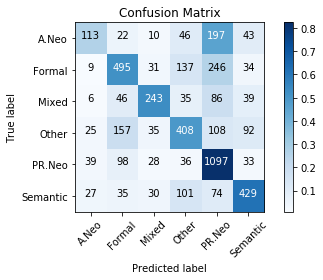

In [30]:
cm = confusion_matrix(y_train, predictions)
lm.pretty_conf_matrix(cm, ['A.Neo','Formal','Mixed','Other','PR.Neo','Semantic'])

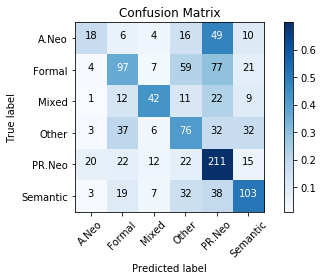

In [31]:
eval_pd=pd.DataFrame()
eval_pd['X1']=X1_val
eval_pd['X2']=X2_val
eval_pd['y']=y_val

acc, predictions=lm.eval_acc(model, eval_pd, c2i, i2c, o2i, i2o)
eval_pd['yhat']=predictions


cm = confusion_matrix(y_val, predictions)
lm.pretty_conf_matrix(cm, ['A.Neo','Formal','Mixed','Other','PR.Neo','Semantic'])


In [32]:
acc

0.47359307359307357

# Mappd Data Exploration

In [33]:
import pandas as pd
#Reference HW3 for RNN starting place

pntfile='pnt_min_mappd.xlsx'
prtfile='prt_min_mappd.xlsx'

pnt=pd.read_excel(pntfile)
prt=pd.read_excel(prtfile)


FileNotFoundError: [Errno 2] No such file or directory: 'pnt_min_mappd.xlsx'

In [ ]:
#prt.groupby('Conventional_response_code').sum()
prt.loc[:,'testtype']='prt'


In [ ]:
pnt.loc[:,'testtype']='pnt'
pnt.groupby('Conventional_response_code').sum()

In [ ]:
combined=prt.append(pnt)
combined.groupby('Conventional_response_code').count()

In [ ]:
combined=combined.drop('Test_iteration',axis=1)
combined.drop_duplicates(inplace=True)

In [ ]:
combined.groupby('Conventional_response_code').count()